In [1]:
#%% Import all necessary libraries
import sys
sys.path.insert(0, '../modules')
import numpy as np
import dask.array as da
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 10})
from sklearn.decomposition import PCA
import time
import napari
from matmatrix import consistentPCA, hullAnalysis, EuAngfromN
import os.path
import glob
import pickle
import msd
from scipy import stats

# time settings in the light sheet
pxum = 0.115
camExposure_ms = 2
sweep_um = 15
stepsize_nm = 400
exp3D_ms = 1e-3 * camExposure_ms * (sweep_um*1e3/stepsize_nm) 
pxum = 0.115

In [8]:
# load all isolated/cropped flagellum
this_file_dir = os.path.dirname(os.path.dirname(os.path.abspath("./")))
folderName = "Flagella-all"

pathThreshold = os.path.join(this_file_dir,
                    "DNA-Rotary-Motor", "Helical-nanotubes",
                    "Light-sheet-OPM", "Result-data",
                    folderName, 'run-07', 'suc40')
pklFiles = glob.glob(pathThreshold + '\*.pkl')
npyFiles = glob.glob(pathThreshold + '\*.npy')

pathIntensity = os.path.join(this_file_dir,
                    "DNA-Rotary-Motor", "Helical-nanotubes",
                    "Light-sheet-OPM", "Result-data",
                    '20211022a_suc40_h15um')
intensityFiles = glob.glob(pathIntensity + '\*.npy')

In [2]:
# load raw images (sample files)
this_file_dir = os.path.dirname(os.path.dirname(os.path.abspath("./")))
samplePath = os.path.join(this_file_dir,
                    'GitHub',
                    'sample-images')
intensityFiles = glob.glob(samplePath + '\*A.npy')
thresholdFiles = glob.glob(samplePath + '\*threshold.npy')

stackTh = da.from_npy_stack(thresholdFiles[0])

In [ ]:
stackTh
for frame in range(len(stackTh)):
# for frame in range(2):

    blob = stackTh[frame]
    X0 = np.argwhere(blob).astype('float') 
    CM1 = np.array([sum(X0[:,j]) for j in range(X0.shape[1])])/X0.shape[0]
    xb0 = X0 - CM1

In [5]:
for frame in range(len(stackTh)):
        # for frame in range(2):
        
    blob = stackTh[frame]
    X0 = np.argwhere(blob).astype('float')
    CM1 = np.array([sum(X0[:,j]) for j in range(X0.shape[1])])/X0.shape[0]
    xb0 = X0 - CM1

    fig = plt.figure(dpi=150, figsize = (7, 6))
    fig.suptitle('data: %s\n' %ThName +
                 'frame-num = ' + str(frame).zfill(3) + ', '
                 'length = %.3f $\mu$m\n' %np.round(lenfla[frame],3) +
                 '$\Delta_\parallel$ = %.3f $\mu$m, ' %np.round(disp[frame,0],3) +
                 '$\Delta_{\perp 1}$ = %.3f $\mu$m, ' %np.round(disp[frame,1],3) +
                 '$\Delta_{\perp 2}$ = %.3f $\mu$m\n' %np.round(disp[frame,2],3) +
                 '$\Delta_\psi$ = %.3f rad, ' %np.round(EuAng[frame,1],3) +
                 '$\Delta_\gamma$ = %.3f rad, ' %np.round(EuAng[frame,0],3) +
                 '$\Delta_\phi$ = %.3f rad\n' %np.round(EuAng[frame,2],3)
                 )
    ax0 = fig.add_subplot(221,projection='3d')
    ax2 = fig.add_subplot(222,projection='3d')
    ax3 = fig.add_subplot(223,projection='3d')
    ax4 = fig.add_subplot(224,projection='3d')
    pxum = 0.115

    ## plot 1
    x, y, z = np.array([[-40,0,0],[0,-40,0],[0,0,-40]])*pxum
    u, v, w = np.array([[60,0,0],[0,60,0],[0,0,60]])*pxum
    ax0.quiver(x,y,z,u,v,w,arrow_length_ratio=0.1, color="black")
    edgePoint = 40
    ax0.set_ylim(-edgePoint*pxum,edgePoint*pxum)
    ax0.set_xlim(-edgePoint*pxum,edgePoint*pxum)
    ax0.set_zlim(-edgePoint*pxum,edgePoint*pxum)
    ax0.view_init(elev=30, azim=30)
    ax0.set_xlabel(r'x [$\mu m$]'); ax0.set_ylabel(r'y [$\mu m$]')
    ax0.set_zlabel(r'z [$\mu m$]')
    ax0.scatter(xb0[:,0]*pxum, xb0[:,1]*pxum,\
                xb0[:,2]*pxum, c = 'k',alpha=0.1, s=10)
    ax0.scatter(endpt[frame,0]*pxum,\
                endpt[frame,1]*pxum,\
                endpt[frame,2]*pxum, c = 'r', alpha=0.5, s=50) 
    origin = [0,0,0]
    X, Y, Z = zip(origin)
    Un1, Vn1, Wn1 = zip(list(5*localAxes[frame,0])) 
    Un2, Vn2, Wn2 = zip(list(5*localAxes[frame,1])) 
    Un3, Vn3, Wn3 = zip(list(5*localAxes[frame,2]))
    ax0.quiver(X,Y,Z,Un1,Vn1,Wn1,color='r')
    ax0.quiver(X,Y,Z,Un2,Vn2,Wn2,color='g')
    ax0.quiver(X,Y,Z,Un3,Vn3,Wn3,color='b')

    ## plot 2
    x, y, z = np.array([[-40,0,0],[0,-40,0],[0,0,-40]])*pxum
    u, v, w = np.array([[60,0,0],[0,60,0],[0,0,60]])*pxum
    ax2.quiver(x,y,z,u,v,w,arrow_length_ratio=0.1, color="black")
    edgePoint = 40
    ax2.set_ylim(-edgePoint*pxum,edgePoint*pxum)
    ax2.set_xlim(-edgePoint*pxum,edgePoint*pxum)
    ax2.set_zlim(-edgePoint*pxum,edgePoint*pxum)
    ax2.view_init(elev=0, azim=90)
    ax2.set_xlabel(r'x [$\mu m$]'); ax2.set_ylabel(r'y [$\mu m$]')
    ax2.set_zlabel(r'z [$\mu m$]')
    ax2.scatter(xb0[:,0]*pxum, xb0[:,1]*pxum,\
                xb0[:,2]*pxum, c = 'k',alpha=0.1, s=10)
    ax2.scatter(endpt[frame,0]*pxum,\
                endpt[frame,1]*pxum,\
                endpt[frame,2]*pxum, c = 'r', alpha=0.5, s=50) 
    origin = [0,0,0]
    X, Y, Z = zip(origin)
    Un1, Vn1, Wn1 = zip(list(5*localAxes[frame,0])) 
    Un2, Vn2, Wn2 = zip(list(5*localAxes[frame,1])) 
    Un3, Vn3, Wn3 = zip(list(5*localAxes[frame,2]))
    ax2.quiver(X,Y,Z,Un1,Vn1,Wn1,color='r')
    ax2.quiver(X,Y,Z,Un2,Vn2,Wn2,color='g')
    ax2.quiver(X,Y,Z,Un3,Vn3,Wn3,color='b')

    ## plot 3
    x, y, z = np.array([[-40,0,0],[0,-40,0],[0,0,-40]])*pxum
    u, v, w = np.array([[60,0,0],[0,60,0],[0,0,60]])*pxum
    ax3.quiver(x,y,z,u,v,w,arrow_length_ratio=0.1, color="black")
    edgePoint = 40
    ax3.set_ylim(-edgePoint*pxum,edgePoint*pxum)
    ax3.set_xlim(-edgePoint*pxum,edgePoint*pxum)
    ax3.set_zlim(-edgePoint*pxum,edgePoint*pxum)
    ax3.view_init(elev=0, azim=0)
    ax3.set_xlabel(r'x [$\mu m$]'); ax3.set_ylabel(r'y [$\mu m$]')
    ax3.set_zlabel(r'z [$\mu m$]')
    ax3.scatter(xb0[:,0]*pxum, xb0[:,1]*pxum,\
                xb0[:,2]*pxum, c = 'k',alpha=0.1, s=10)
    ax3.scatter(endpt[frame,0]*pxum,\
               endpt[frame,1]*pxum,\
               endpt[frame,2]*pxum, c = 'r', alpha=0.5, s=50) 
    origin = [0,0,0]
    X, Y, Z = zip(origin)
    Un1, Vn1, Wn1 = zip(list(5*localAxes[frame,0])) 
    Un2, Vn2, Wn2 = zip(list(5*localAxes[frame,1])) 
    Un3, Vn3, Wn3 = zip(list(5*localAxes[frame,2]))
    ax3.quiver(X,Y,Z,Un1,Vn1,Wn1,color='r')
    ax3.quiver(X,Y,Z,Un2,Vn2,Wn2,color='g')
    ax3.quiver(X,Y,Z,Un3,Vn3,Wn3,color='b')

    ## plot 4
    x, y, z = np.array([[-40,0,0],[0,-40,0],[0,0,-40]])*pxum
    u, v, w = np.array([[60,0,0],[0,60,0],[0,0,60]])*pxum
    ax4.quiver(x,y,z,u,v,w,arrow_length_ratio=0.1, color="black")
    edgePoint = 40
    ax4.set_ylim(-edgePoint*pxum,edgePoint*pxum)
    ax4.set_xlim(-edgePoint*pxum,edgePoint*pxum)
    ax4.set_zlim(-edgePoint*pxum,edgePoint*pxum)
    ax4.view_init(elev=90, azim=0)
    ax4.set_xlabel(r'x [$\mu m$]'); ax4.set_ylabel(r'y [$\mu m$]')
    ax4.set_zlabel(r'z [$\mu m$]')
    ax4.scatter(xb0[:,0]*pxum, xb0[:,1]*pxum,\
                xb0[:,2]*pxum, c = 'k',alpha=0.1, s=10)
    ax4.scatter(endpt[frame,0]*pxum,\
               endpt[frame,1]*pxum,\
               endpt[frame,2]*pxum, c = 'r', alpha=0.5, s=50) 
    origin = [0,0,0]
    X, Y, Z = zip(origin)
    Un1, Vn1, Wn1 = zip(list(5*localAxes[frame,0])) 
    Un2, Vn2, Wn2 = zip(list(5*localAxes[frame,1])) 
    Un3, Vn3, Wn3 = zip(list(5*localAxes[frame,2]))
    ax4.quiver(X,Y,Z,Un1,Vn1,Wn1,color='r')
    ax4.quiver(X,Y,Z,Un2,Vn2,Wn2,color='g')
    ax4.quiver(X,Y,Z,Un3,Vn3,Wn3,color='b')
    #ax4.figure.savefig(os.path.join(savingFolder, ThName + '-' + 
    #                                str(frame).zfill(3) + '.png'))
    plt.show()

TypeError: 'float' object cannot be interpreted as an integer

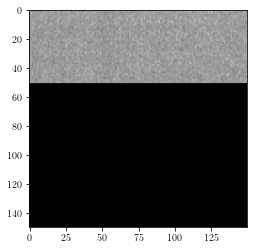

In [29]:
fig = plt.Figure()
plt.imshow(test[0,20,:,:],cmap='gray', vmin=0, vmax=200)

In [28]:
test

,Array,Chunk
Bytes,1.61 GiB,5.49 MiB
Shape,"(300, 128, 150, 150)","(1, 128, 150, 150)"
Count,300 Tasks,300 Chunks
Type,uint16,numpy.ndarray


In [8]:
test = da.from_npy_stack(intensityFiles[0])
viewer = napari.Viewer(ndisplay=3)      
viewer.add_image(test, contrast_limits=[100,200],\
                    scale=[0.115,.115,.115],\
                    multiscale=False,colormap='gray',opacity=0.5)
viewer.add_image(stackTh, contrast_limits=[0,1],\
                    scale=[0.115,.115,.115],\
                    multiscale=False,colormap='green',opacity=0.5)
viewer.scale_bar.visible=True
viewer.scale_bar.unit='um'
viewer.scale_bar.position='top_right'
viewer.axes.visible = True
napari.run()